In [7]:
# LOAD LIBRARY
import pandas as pd
from supabase import create_client, Client
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns


In [8]:
# LOAD CONNECTION TO SUPABASE
load_dotenv()
supabase_url = os.getenv("SUPABASE_URL")
supabase_key = os.getenv("SUPABASE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

In [9]:
# GET DATABASE 
response = supabase.table("feedback_ir").select("id, created_at, user, query, result").execute()
data = response.data


In [10]:
df = pd.DataFrame(data)
df.head()

,id,created_at,user,query,result
0,6,2025-05-11T23:31:30.069778+00:00,devvevan@gmail.com,apa itu ikhlas,"[{'id': 3008, 'indoText': 'Sesungguhnya mereka..."
1,7,2025-05-11T23:32:16.897893+00:00,devvevan@gmail.com,apa itu jalan yang lurus?,"[{'id': 5, 'indoText': 'Tunjukilah kami jalan ..."
2,8,2025-05-12T03:11:07.033114+00:00,devvevan@gmail.com,apa itu ikhlas,"[{'id': 3008, 'indoText': 'Sesungguhnya mereka..."
3,9,2025-05-12T07:17:58.651473+00:00,devvevan@gmail.com,apa itu ikhlas,"[{'id': 3008, 'indoText': 'Sesungguhnya mereka..."
4,10,2025-05-12T07:18:54.836548+00:00,devvevan@gmail.com,apa itu tuhan yang maha esa,"[{'id': 169, 'indoText': 'Dan Tuhan kamu adala..."


In [11]:
def parse_result(val):
    if isinstance(val, str):
        try:
            return json.loads(val)
        except:
            return []
    elif isinstance(val, list):
        return val
    return []

df['result'] = df['result'].apply(parse_result)

# --- 5. (Opsional) Meledakkan result menjadi baris-baris baru ---
# Setiap baris hasil explode mewakili 1 entri dalam result
df_exploded = df.explode('result').reset_index(drop=True)

# --- 6. Ubah dict di kolom result jadi kolom-kolom terpisah ---
result_details = pd.json_normalize(df_exploded['result'])
df_final = pd.concat([df_exploded.drop(columns=['result']), result_details], axis=1)
df_final.head()


,id,created_at,user,query,id,indoText,suraId,verseID,is_relevan
0,6,2025-05-11T23:31:30.069778+00:00,devvevan@gmail.com,apa itu ikhlas,3008,Sesungguhnya mereka (apa yang kamu sembah) itu...,26,77,False
1,6,2025-05-11T23:31:30.069778+00:00,devvevan@gmail.com,apa itu ikhlas,5324,apakah hari Kiamat itu?,69,2,False
2,6,2025-05-11T23:31:30.069778+00:00,devvevan@gmail.com,apa itu ikhlas,5365,Ia (Al-Qur'an) adalah wahyu yang diturunkan da...,69,43,False
3,6,2025-05-11T23:31:30.069778+00:00,devvevan@gmail.com,apa itu ikhlas,6158,Apakah hari Kiamat itu?,101,2,False
4,6,2025-05-11T23:31:30.069778+00:00,devvevan@gmail.com,apa itu ikhlas,6208,"aku tidak akan menyembah apa yang kamu sembah,",109,2,False


In [12]:
# Fungsi hitung Precision@k dan Recall@k
def precision_recall_at_k(results, k=5):
    top_k = results[:k]
    total_relevant = sum([r['is_relevan'] for r in results])
    relevant_in_top_k = sum([r['is_relevan'] for r in top_k])
    
    precision = relevant_in_top_k / k if k > 0 else 0
    recall = relevant_in_top_k / total_relevant if total_relevant > 0 else 0
    return precision, recall

# Buat list untuk simpan hasil
precision_list = []
recall_list = []

# Iterasi tiap query (tiap baris)
for idx, row in df.iterrows():
    results = row['result']
    precision, recall = precision_recall_at_k(results, k=5)
    precision_list.append(precision)
    recall_list.append(recall)

# Tambahkan ke DataFrame
df['precision@5'] = precision_list
df['recall@5'] = recall_list
df.head()

,id,created_at,user,query,result,precision@5,recall@5
0,6,2025-05-11T23:31:30.069778+00:00,devvevan@gmail.com,apa itu ikhlas,"[{'id': 3008, 'indoText': 'Sesungguhnya mereka...",0.0,0.0
1,7,2025-05-11T23:32:16.897893+00:00,devvevan@gmail.com,apa itu jalan yang lurus?,"[{'id': 5, 'indoText': 'Tunjukilah kami jalan ...",0.4,1.0
2,8,2025-05-12T03:11:07.033114+00:00,devvevan@gmail.com,apa itu ikhlas,"[{'id': 3008, 'indoText': 'Sesungguhnya mereka...",0.0,0.0
3,9,2025-05-12T07:17:58.651473+00:00,devvevan@gmail.com,apa itu ikhlas,"[{'id': 3008, 'indoText': 'Sesungguhnya mereka...",0.0,0.0
4,10,2025-05-12T07:18:54.836548+00:00,devvevan@gmail.com,apa itu tuhan yang maha esa,"[{'id': 169, 'indoText': 'Dan Tuhan kamu adala...",0.4,1.0


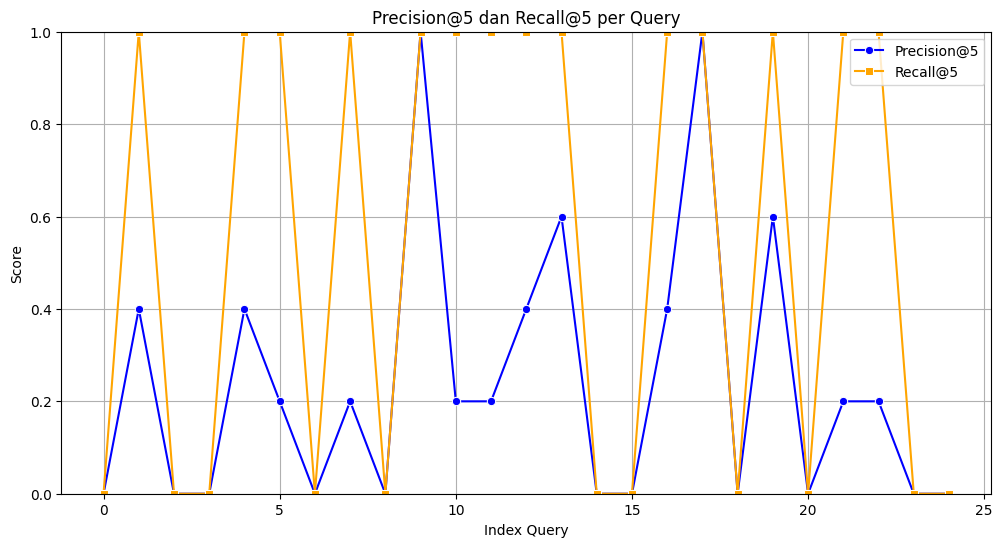

In [ ]:
# Visualisasi
plt.figure(figsize=(12, 6))

# Plot Precision@5
sns.lineplot(data=df, x=df.index, y='precision@5', marker='o', label='Precision@5', color='blue')

# Plot Recall@5
sns.lineplot(data=df, x=df.index, y='recall@5', marker='s', label='Recall@5', color='orange')

# Styling
plt.title('Precision@5 dan Recall@5 per Query')
plt.xlabel('Index Query')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# Tampilkan plot
plt.show()